# Project: Geo-pulse - Clustering of area_codes

---

## 1. Importing Libraries

In [1]:
# General Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sci-kit learn Library
# Machine learning models
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.ensemble import RandomForestClassifier

# Pre-process
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import classification_report

# Setting palette
sns.set_palette('colorblind')
sns.set_style("whitegrid", {'axes.grid' : False})

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/geo_cleaned.csv', index_col=[0])

In [3]:
df.drop(columns=['area_code','hour'],inplace=True)

In [4]:
df.head()

,segment,density,pre_paid,post_paid,gender_male,gender_female,gender_unknown,age_1_19,age_20_29,age_30_39,...,pct_fastfood_app_user,pct_food_delivery_app_user,pct_grocery_delivery_app_user,pct_inte_coffee_lover,pct_inte_travel_and_information,pct_inte_investment,pct_inte_realestate,pct_inte_insurance,pct_inte_automobile,pct_inte_fitness_and_wellness
0,visitor,28,9,19,5,11,12,6,7,6,...,0.035714,0.392857,0.107143,0.357143,0.142857,0.107143,0.071429,0.000000,0.107143,0.107143
1,visitor,37,17,20,10,8,19,8,3,13,...,0.027027,0.189189,0.027027,0.162162,0.027027,0.054054,0.000000,0.000000,0.108108,0.081081
2,worker,43,21,22,11,9,23,5,7,19,...,0.000000,0.186047,0.186047,0.116279,0.069767,0.069767,0.093023,0.069767,0.116279,0.093023
3,visitor,21,12,9,8,6,7,3,7,5,...,0.000000,0.190476,0.190476,0.190476,0.000000,0.000000,0.000000,0.000000,0.047619,0.047619
4,work_at_home,31,11,20,6,7,18,3,2,11,...,0.000000,0.193548,0.096774,0.354839,0.032258,0.064516,0.064516,0.000000,0.129032,0.032258


---

## 2. Data Preparation

**Select only population density column**

In [5]:
# time_of_day to divide the clustering
# segment and density will be our features to cluster
df = df[['segment','density','time_of_day']]

---

## 3. KMeans by time of the day

We have separated our segments into 4 segments - `visitor`, `worker`, `resident`, and `work_at_home` - because every grid is unique, therefore comparing different segments at different locations will not be beneficial. Focusing on each segment, we will do unsupervised clustering based on `time_of_day` - `Morning`, `Work`, `Afterwork`, `Sleep`. This should be able to provide us with some clues on how the grids can be cluster and what sets each grids apart.

However, if each binning of segments and time_of_day has too little rows of data, then clustering will not work. We will select only groups of grids with > 40 rows to do clustering.

In [6]:
grouped = df.groupby(['time_of_day'])['density'].count()\
.to_frame()
grouped['Usability'] = grouped['density'].map(
    lambda x : np.where(x < 40, 'too small', 'can use'))

In [7]:
grouped.style.background_gradient()

,density,Usability
time_of_day,,
Afterwork,259,can use
Morning,148,can use
Sleep,227,can use
Work,358,can use


**Creating function to identify optimal k using both inertia elbow method and silhouette coefficients distribution**

In [8]:
def cluster(segment,time, max_cluster):
    
    X = segment[segment['time_of_day'] == time].drop(
        columns=['time_of_day'])
    X = pd.get_dummies(X,columns=['segment'],drop_first=True)
    
    # Inertia
    km = KMeans(random_state=42)
    visualizer = KElbowVisualizer(km,k=(2,max_cluster))
    visualizer.fit(X)
    visualizer.show()
    
    # Silhouette Score
    fig, ax = plt.subplots(max_cluster//2, 2, figsize=(10,max_cluster))
    
    for i in range(2,max_cluster+1):

        km = KMeans(n_clusters=i, init='k-means++', n_init=10,
                    max_iter=100, random_state=42)
        q, mod = divmod(i, 2)
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick',
                                          ax=ax[q-1][mod])
        visualizer.fit(X)
        
    plt.tight_layout()

### 3.1 Morning Hours

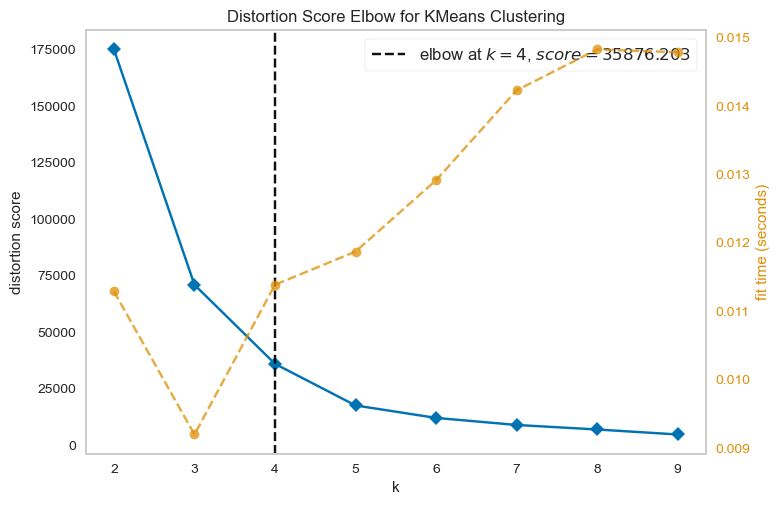

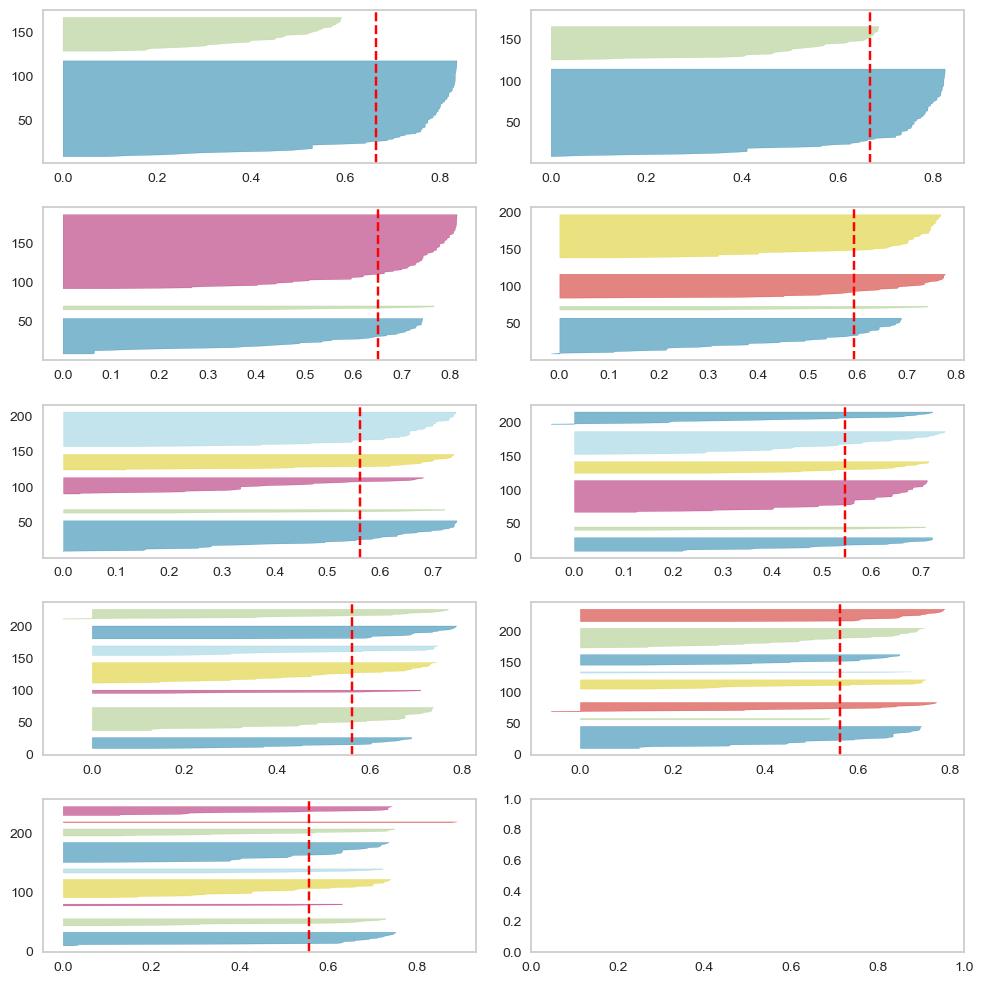

In [9]:
cluster(df,'Morning',10)

**Interpretation:**
- Elbow method suggested the optimal k is 4
- Looking at the Silhouette coefficients distribution of each k and the evenness of clusters, we k = 3 or 4 should do the tricks one will always be an outlier
- We will try both 3 and 4 clusters, then assess the insights we get from them

### 3.2 Working Hours

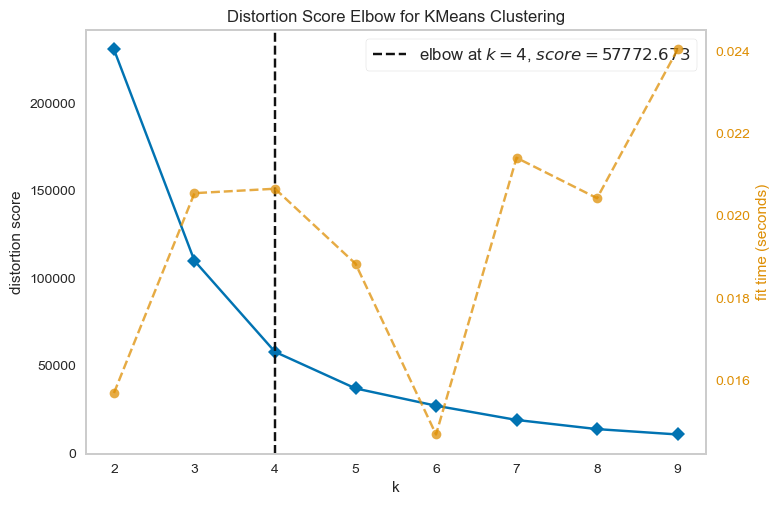

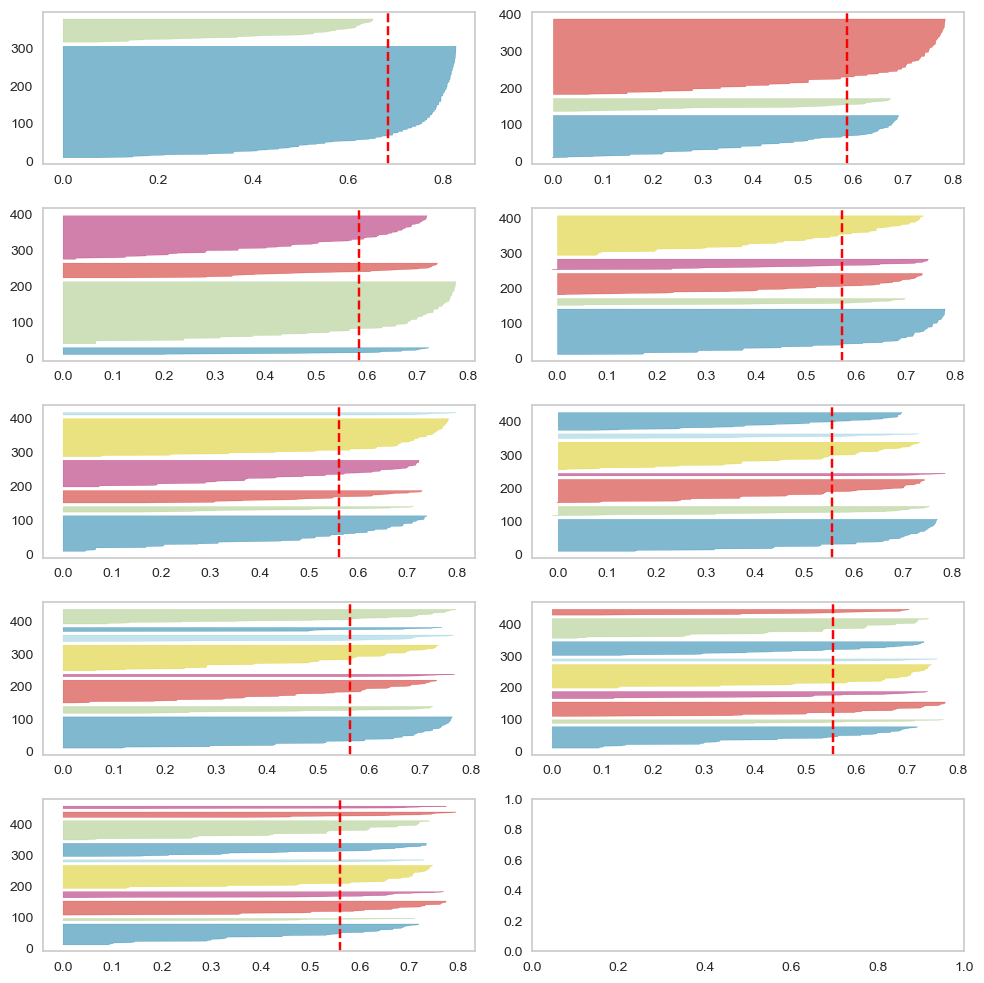

In [10]:
cluster(df,'Work',10)

**Interpretation:**
- Elbow method suggested the optimal k is 4
- Looking at the Silhouette coefficients distribution of each k and the evenness of clusters, k = 3-5 seems to create a sensible grouping
- We will try both 3-5 clusters, then assess the insights we get from them

### 3.3 Afterwork

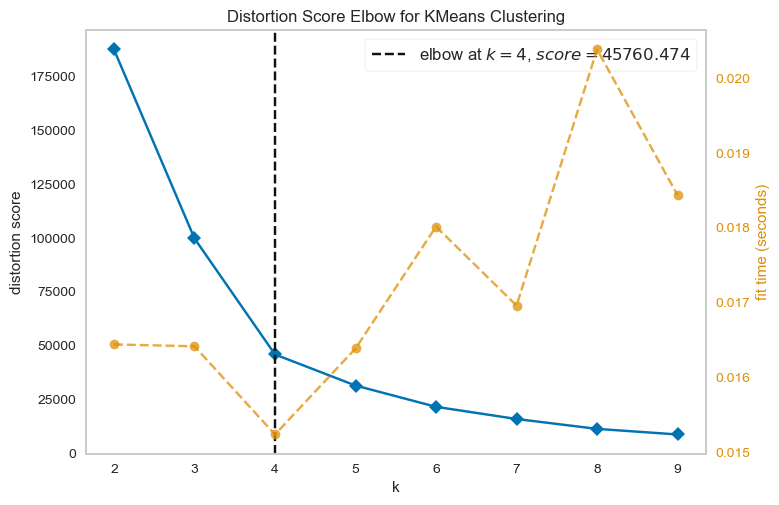

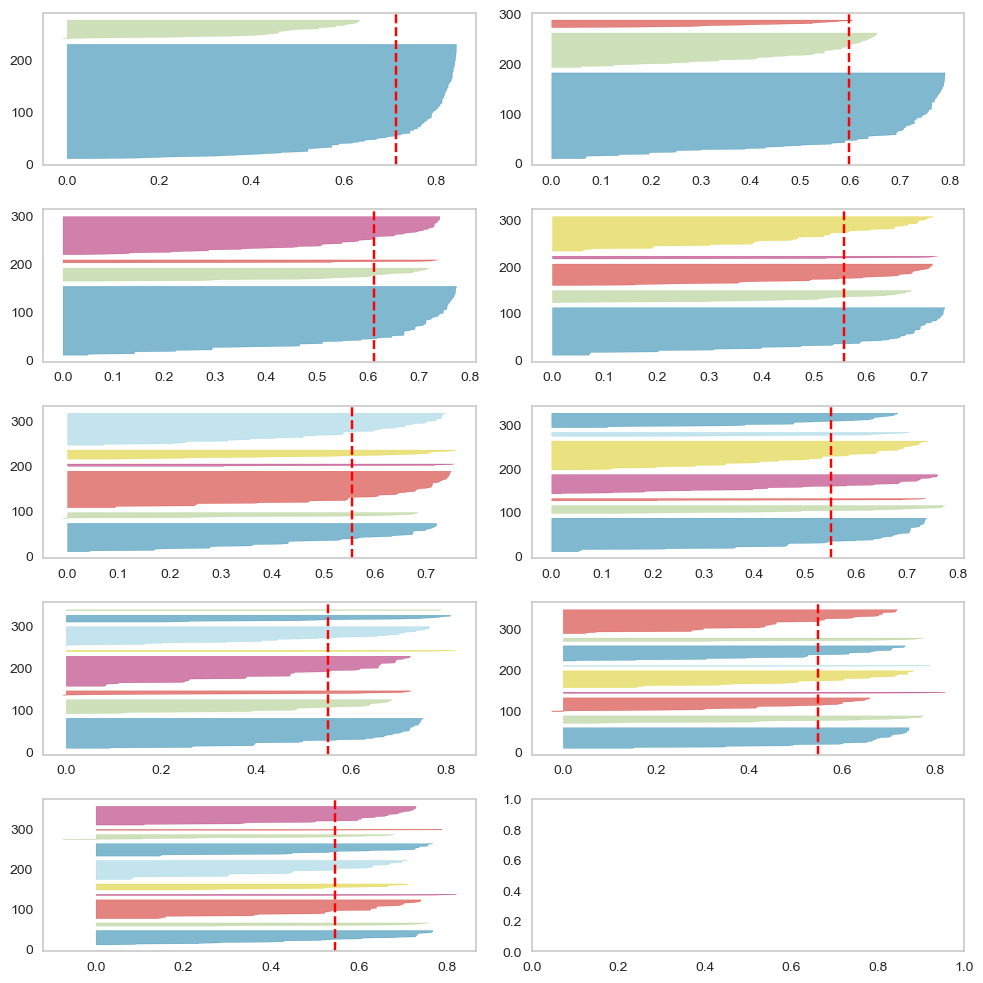

In [11]:
cluster(df,'Afterwork',10)

**Interpretation:**
- Elbow method suggested the optimal k is 4
- Looking at the Silhouette coefficients distribution of each k and the evenness of clusters, k = 4 should work best as an outlier group always exist
- We will try 4 clusters, then assess the insights we get from them

### 3.4 Sleeping time

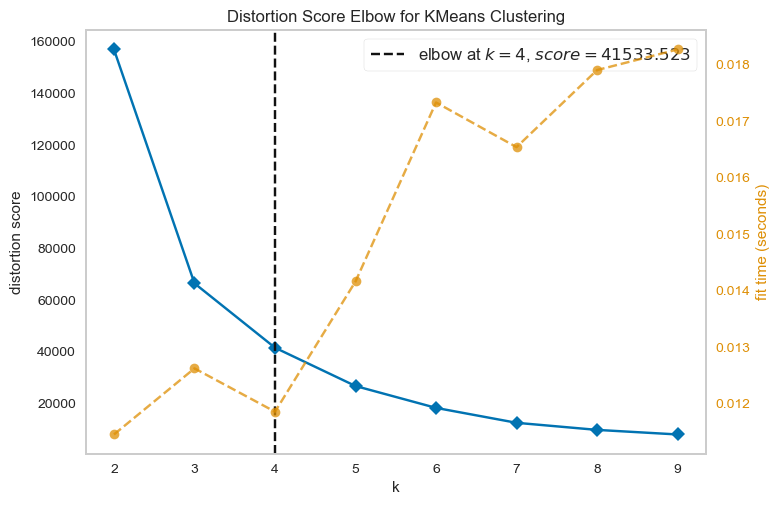

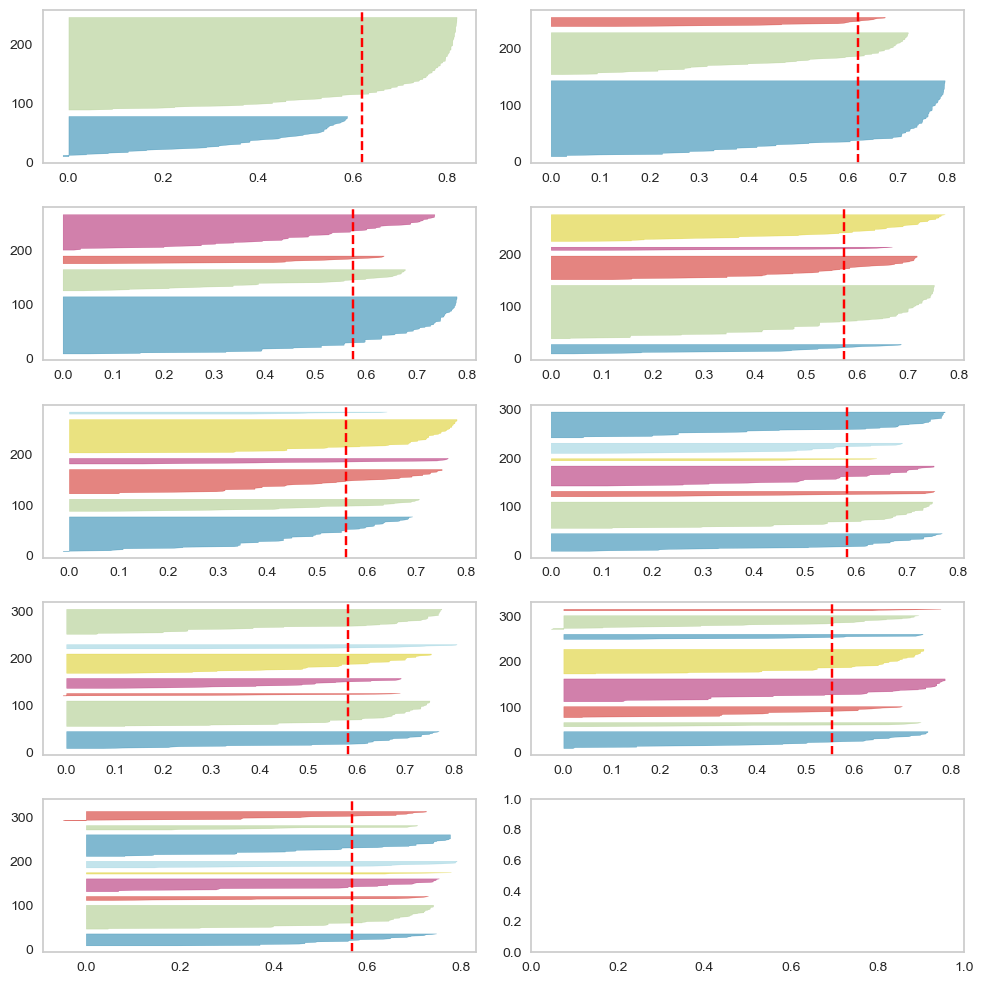

In [12]:
cluster(df,'Sleep',10)

**Interpretation:**
- Elbow method suggested the optimal k is 4
- Looking at the Silhouette coefficients distribution of each k and the evenness of clusters, k = 4 is definitely the winner in this case
- We will try 4 clusters, then assess the insights we get from them

---

## 4. Unsupervised KMeans clustering feeding into Supervised classifier to identify feature importance and grouping based on real world scenarios

**Function to generate labels based on selected `n_clusters`, with the option of separating the dataset by `time_of_day`**

In [13]:
def km_label(df,time_of_day,num_clusters):

    clf_df = df[df['time_of_day']==time_of_day]
    X = clf_df.copy().drop(columns=['time_of_day'])
    X = pd.get_dummies(X, columns=['segment'])
    km = KMeans(n_clusters=num_clusters, random_state=42)
    km.fit(X)

    clf_df['labels'] = km.labels_
    X['labels'] = km.labels_
    
    clf_gb = (X.groupby('labels').agg({'density': ['count', 'mean'],
                                      'segment_visitor':['mean'],
                                      'segment_work_at_home':['mean'],
                                      'segment_worker':['mean'],
                                      'segment_resident':['mean']}).round(2))
    clf_gb.round(2)

    return X, clf_df, clf_gb

**Function to create classification report**

In [14]:
def clf_reports(model,clf_df):
    clf = model
    X = clf_df.drop(columns=['labels'])
    y = clf_df['labels']
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test,y_pred))
    
    result = pd.DataFrame({'feature':clf.feature_names_in_,
                                       'importance':clf.feature_importances_})
    result = result.sort_values(by='importance',ascending=False)
    
    return result

**Function to create KDE of each clusters**

In [15]:
def plot_kde_by_labels(df,time):
    plt.figure(figsize=(4,4))
    plt.title(f"Scatter plot of population density distribution of {time} bin of data")
    sns.kdeplot(data=df,x='density',hue='labels')

### 4.1 Morning Hours: 05:00 - 09:00

In [16]:
morning_X, morning_clf_df,morning_clf_gb = km_label(df,'Morning',4)
important_features = clf_reports(RandomForestClassifier(random_state=42),morning_X)
important_features

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        22

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



,feature,importance
0,density,0.949517
3,segment_work_at_home,0.029705
1,segment_resident,0.008072
2,segment_visitor,0.007901
4,segment_worker,0.004804


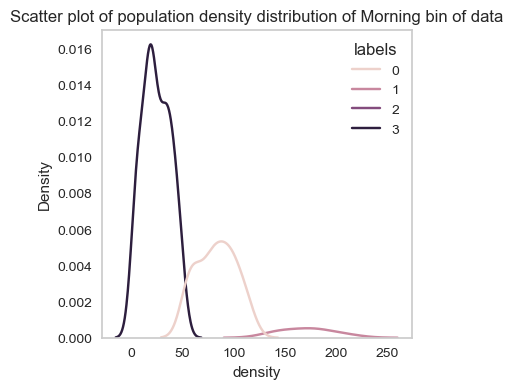

In [17]:
plot_kde_by_labels(morning_clf_df,'Morning')

In [18]:
morning_clf_gb

density         segment_visitor segment_work_at_home segment_worker  \
         count    mean            mean                 mean           mean   
labels                                                                       
0           46   82.93            0.24                 0.52           0.15   
1            6  170.83            0.17                 0.83           0.00   
2            1  431.00            1.00                 0.00           0.00   
3           95   24.42            0.39                 0.27           0.13   

       segment_resident  
                   mean  
labels                   
0                  0.09  
1                  0.00  
2                  0.00  
3                  0.21

**Interpretation:** <br>

Density:
- Low <= 40
- 40 < Medium <= 80
- 80 < High

Cluster Type:
- Residential : Mostly work_at_home and resident / little to no visitor and workers
- Office : Some visitors and workers / little to no resident and work_at_home
- Community : A little bit of all but resident > worker
- Community Office : A little bit of all but worker > resident
- Public : Mostly visitors


**This interpretation will be applied to other bin as well**

In [19]:
# Mapping to morning_results dataframe
morning_results = morning_clf_df.copy()
morning_results['density_level'] = morning_results['labels'].map({0:'medium',1:'high',2:'high',3:'low'})
morning_results['location_type'] = morning_results['labels'].map({0:'community office',1:'residential',\
    2:'public',3:'community office'})

### 4.2 Working Hours: 09:00 - 17:00

In [20]:
working_x, working_clf_df,working_clf_gb = km_label(df,'Work',4)
important_features = clf_reports(RandomForestClassifier(random_state=42), working_x)
important_features.head(5)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00        43
           2       0.90      1.00      0.95         9
           3       1.00      1.00      1.00        34

    accuracy                           0.99        90
   macro avg       0.97      0.94      0.95        90
weighted avg       0.99      0.99      0.99        90



,feature,importance
0,density,0.954228
3,segment_work_at_home,0.021630
1,segment_resident,0.017213
4,segment_worker,0.004257
2,segment_visitor,0.002673


In [21]:
working_clf_gb

density         segment_visitor segment_work_at_home segment_worker  \
         count    mean            mean                 mean           mean   
labels                                                                       
0           20  181.65            0.25                 0.35           0.40   
1          174   18.47            0.39                 0.22           0.25   
2           42  105.95            0.26                 0.55           0.19   
3          122   54.89            0.31                 0.49           0.20   

       segment_resident  
                   mean  
labels                   
0                  0.00  
1                  0.15  
2                  0.00  
3                  0.00

In [22]:
# Mapping to working_results dataframe
working_results = working_clf_df.copy()
working_results['density_level'] = working_results['labels'].map({0:'high',1:'low',2:'high',3:'medium'})
working_results['location_type'] = working_results['labels'].map({0:'community_office',1:'community',
2:'community_office',3:'community_office'})

### 4.3 Afterwork: 17:00 - 23:00

In [23]:
afterwork_x, afterwork_clf_df,afterwork_clf_gb = km_label(df,'Afterwork',4)
important_features = clf_reports(RandomForestClassifier(random_state=42), afterwork_x)
important_features.head(5)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00        21

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



,feature,importance
0,density,0.939614
3,segment_work_at_home,0.032533
4,segment_worker,0.017010
2,segment_visitor,0.005806
1,segment_resident,0.005036


In [24]:
afterwork_clf_gb

density         segment_visitor segment_work_at_home segment_worker  \
         count    mean            mean                 mean           mean   
labels                                                                       
0          144   20.52            0.33                 0.23           0.15   
1           28  120.39            0.25                 0.68           0.00   
2            7  230.14            0.29                 0.71           0.00   
3           80   58.58            0.32                 0.48           0.00   

       segment_resident  
                   mean  
labels                   
0                  0.29  
1                  0.07  
2                  0.00  
3                  0.20

In [25]:
# Mapping to morning_results dataframe
afterwork_results = afterwork_clf_df.copy()
afterwork_results['density_level'] = afterwork_results['labels'].map({0:'low',1:'high',2:'high',3:'medium'})
afterwork_results['location_type'] = afterwork_results['labels'].map({0:'community_office',1:'community',
2:'residential',3:'residential'})

### 4.4 Sleeping Time : 23:00-05:00

In [26]:
sleeping_x, sleeping_clf_df, sleeping_clf_gb = km_label(df,'Sleep',4)
important_features = clf_reports(RandomForestClassifier(random_state=42),sleeping_x)
important_features.head(5)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       0.83      1.00      0.91        10
           2       1.00      0.50      0.67         4
           3       1.00      0.88      0.93        16

    accuracy                           0.93        57
   macro avg       0.94      0.84      0.87        57
weighted avg       0.94      0.93      0.93        57



,feature,importance
0,density,0.941990
3,segment_work_at_home,0.022015
2,segment_visitor,0.021249
1,segment_resident,0.011641
4,segment_worker,0.003104


In [27]:
sleeping_clf_gb

density         segment_visitor segment_work_at_home segment_worker  \
         count    mean            mean                 mean           mean   
labels                                                                       
0          106   19.06            0.39                 0.32           0.04   
1           40   92.68            0.08                 0.55           0.00   
2           15  169.67            0.07                 0.67           0.00   
3           66   54.03            0.21                 0.39           0.00   

       segment_resident  
                   mean  
labels                   
0                  0.25  
1                  0.38  
2                  0.27  
3                  0.39

In [28]:
# Mapping to morning_results dataframe
sleeping_results = sleeping_clf_df.copy()
sleeping_results['density_level'] = sleeping_results['labels'].map({0:'low',1:'high',2:'high',3:'medium'})
sleeping_results['location_type'] = sleeping_results['labels'].map({0:'community_office',1:'residential',
2:'residential',3:'residential'})

---

**Binning by segment is easier to interpret**